# Bandit Assignment

This assignment should be done in groups of 3 and consists of a number of implementation and theory problems based on the topics discussed in the lectures and the course literature (specifically, **version 5** on arXiv):

[Bandits] *Aleksandrs Slivkins, [Introduction to Multi-Armed Bandits](https://arxiv.org/pdf/1904.07272v5.pdf), Found. Trends Mach. Learn. 12(1-2): 1-286 (2019)*

In the implementation problems **(1, 2, 3 and 5)**, you will implement multi-armed bandit algorithms from the [Bandits] book and use them in a provided multi-armed bandit environment. These problems will be graded based on the correctness of the code.

In the theory problems **(4 and 6)**, you will derive some properties of the algorithms. These problems will be graded based on the correctness of the arguments.

You may use the python libraries imported below (*numpy*, *scipy.stats* and *pandas*).

The assignment should be handed in as an updated notebook. The entire notebook should be run before it is handed in, so that the plots are visible. Ensure that it is completely runnable, in the case that we want to reproduce the results. 

## Setup

The cell below contains imports. It may not be modified!

In [14]:
# DO NOT MODIFY
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import random

SEED = 150
ITERATIONS = 10
K = 100
T = 10000

The cell below contains the bandit environment and may not be modified!

In [15]:
# DO NOT MODIFY
class Environment:
    def __init__(self, K=10, seed=0):
        self.random_state = np.random.RandomState(seed=seed)
        self.mu = st.beta.rvs(a=1, b=1, size=K, random_state=self.random_state)
        
    def expected_value(self, a):
        return self.mu[a]
        
    def perform_action(self, a):
        return st.bernoulli.rvs(self.mu[a], random_state=self.random_state)
        
    def optimal_action(self):
        return np.argmax(self.mu)

The cell below contains the bandit algorithm base class and may not be modified!

In [16]:
# DO NOT MODIFY
class BanditAlgorithmBase:
    def select_action(self):
        pass
    
    def update(self, action, reward):
        pass

The cell below contains the bandit experiment and may not be modified!

In [17]:
# DO NOT MODIFY
class Experiment:
    def __init__(self, environment, bandit_algorithm):
        self.environment = environment
        self.bandit_algorithm = bandit_algorithm
        
    def run_experiment(self, T=100):
        instant_regrets = np.zeros(T)
        for t in range(0, T):
            action = self.bandit_algorithm.select_action()
            reward = self.environment.perform_action(action)
            self.bandit_algorithm.update(action, reward)
            
            optimal_action = self.environment.optimal_action()
            instant_regret = self.environment.expected_value(optimal_action) - self.environment.expected_value(action)
            instant_regrets[t] = instant_regret
        cumulative_regrets = np.cumsum(instant_regrets)
        return (instant_regrets, cumulative_regrets)
            

The cell below contains a function for repeated experiments with a provided bandit algorithm, averaging regret over the runs. It may not be modified!

In [18]:
# DO NOT MODIFY
def run_repeated_experiments(bandit_algorithm_class, seed):
    instant_regrets = []
    cumulative_regrets = []
    for i in range(ITERATIONS):
        bandit_algorithm = bandit_algorithm_class(T, K)
        environment = Environment(K, seed+i+1)
        experiment = Experiment(environment, bandit_algorithm)

        instant_regrets_i, cumulative_regrets_i = experiment.run_experiment(T)
        instant_regrets.append(instant_regrets_i)
        cumulative_regrets.append(cumulative_regrets_i)
    return pd.DataFrame(data={'t': np.arange(1, T+1),
                             'instant_regret': np.mean(np.vstack(np.array(instant_regrets)), axis=0),
                             'regret': np.mean(np.vstack(np.array(cumulative_regrets)), axis=0)})


## Stochastic Bandits (Chapter 1)

### Problem 1 
(3 points)

Implement the *Explore-First* algorithm (**Algorithm 1.1** in [Bandits]) within the provided bandit algorithm template below. Use $N = \left(\frac{T}{K}\right)^{2/3} \cdot \left( \log T \right)^{1/3}$.

In [19]:
class ExploreFirst(BanditAlgorithmBase):

    def __init__(self, T, K):
        """
        Constructor of the bandit algorithm

        Parameters
        ----------
        T : int
            Horizon

        K : int
            Number of actions
        """
        
        self.N = int((T/K)**(2/3) * np.log(T)**(1/3))
        self.rewards = [[] for _ in range(K)]
        self.explore = self.N*K
        self.avg_rewards = []
        self.explore_list = []

        # Initialize the explore list
        for _ in range(self.N):
            for i in range (K):
                self.explore_list.append(i) 
    
    def select_action(self):
        """
        Select an action which will be performed in the environment in the 
        current time step

        Returns
        -------
        An action index (integer) in [0, K-1]
        """
        
        if self.explore_list:
            # random variable from length of explore_lista (redundant random?)
            rand_index = random.randint(0, len(self.explore_list)-1)
            action = self.explore_list.pop(rand_index)
            return action
        
        # calculate the if they have not been calculated yet
        if not self.avg_rewards:
            self.avg_rewards = [np.mean(reward) for reward in self.rewards]
        
        return np.argmax(self.avg_rewards)
        
    
    def update(self, action, reward):
        """
        Update the bandit algorithm with the reward received from the 
        environment for the action performed in the current time step

        Parameters
        ----------
        action : int
            An action index (integer) in [0, K-1]
        reward : int
            Reward (integer) in {0, 1} (Bernoulli rewards)

        """

        self.rewards[action].append(reward)
    
        

Run the algorithm in the provided environment using the code below (averaging regret over 5 runs). The exploration and exploitation phases should be clearly visible in the plot.

<Axes: title={'center': 'Explore-First'}, xlabel='t'>

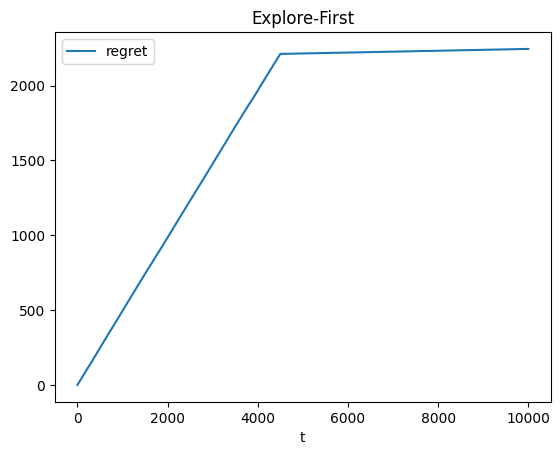

In [20]:
# DO NOT MODIFY
np.random.seed(SEED)
ef_df = run_repeated_experiments(ExploreFirst, SEED)
ef_df.plot(x='t', y='regret', title='Explore-First')

### Problem 2
(3 points) 

Implement the $ \epsilon_t $-*Greedy* algorithm (**Algorithm 1.2** in [Bandits]) within the provided bandit algorithm template below. Use $\epsilon_t = \min \left\{1,\ t^{-1/3} \cdot (K \log t)^{1/3}\right\} $.

In [21]:
class EpsilonTGreedy(BanditAlgorithmBase):
    def __init__(self, T, K):
        """
        Constructor of the bandit algorithm
        
        Parameters
        ----------
        T : int
            Horizon
        K : int
            Number of actions
        """
        
        self.T = T
        self.K = K
        self.rewards = [[] for _ in range(self.K)]
        self.avg_rewards = [0 for _ in range(self.K)]
        self.epsilon = min(1, T**(-1/3)*(K*np.log(T))**(1/3))    
    
    def select_action(self):
        """
        Select an action which will be performed in the environment in the 
        current time step

        Returns
        -------
        An action index (integer) in [0, K-1]
        """
        randNum =  random.random()

        if randNum > self.epsilon:
            #Exploitation, choose the action that gives the higest reward 
            return np.argmax(self.avg_rewards) # argmax returns the indice of the maximum value
        else:
          # Exploration, choose a random action to explore the possible outcomes
            return np.random.randint(self.K)
        
    
    def update(self, action, reward):
        """
        Update the bandit algorithm with the reward received from the 
        environment for the action performed in the current time step

        Parameters
        ----------
        action : int
            An action index (integer) in [0, K-1]
        reward : int
            Reward (integer) in {0, 1} (Bernoulli rewards)

        """
        self.rewards[action].append(reward)
        self.avg_rewards[action] = np.mean(self.rewards[action])

Run the algorithm in the provided environment using the code below (averaging regret over 5 runs). The plot should show sublinear regret with respect to $t$.

<Axes: title={'center': 'Epsilon_t-Greedy'}, xlabel='t'>

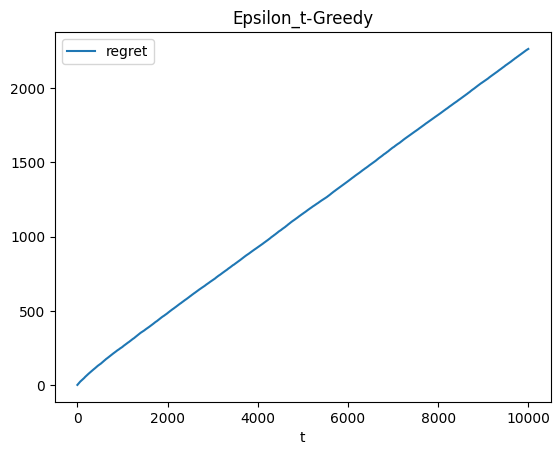

In [22]:
# DO NOT MODIFY
np.random.seed(SEED)
eg_df = run_repeated_experiments(EpsilonTGreedy, SEED)
eg_df.plot(x='t', y='regret', title='Epsilon_t-Greedy')

### Problem 3
(3 points) 

Implement the UCB1 algorithm (**Algorithm 1.5** in [Bandits]) within the provided bandit algorithm template below.

In [23]:
class UCB1(BanditAlgorithmBase):
    def __init__(self, T, K):
        """
        Constructor of the bandit algorithm

        Parameters
        ----------
        T : int
            Horizon
        K : int
            Number of actions
        """
        
        # FILL IN CODE HERE
        self.T = T
        self.K = K
        self.rewards = [[] for _ in range(self.K)]
        self.avg_rewards = [0 for _ in range(self.K)]
        self.times_tested = [0 for _ in range(self.K)]
        self.UCB = [0 for _ in range(self.K)]
        self.initial_counter = 0

        # r = np.sqrt((2*np.log(T))/n_t)
    
    def select_action(self):
        """
        Select an action which will be performed in the environment in the 
        current time step

        Returns
        -------
        An action index (integer) in [0, K-1]
        """
        
        if self.initial_counter < self.K:
            action = self.initial_counter
            self.initial_counter += 1
            return action

        return np.argmax(self.UCB)
    
    def update(self, action, reward):
        """
        Update the bandit algorithm with the reward received from the 
        environment for the action performed in the current time step

        Parameters
        ----------
        action : int
            An action index (integer) in [0, K-1]
        reward : int
            Reward (integer) in {0, 1} (Bernoulli rewards)

        """

        self.rewards[action].append(reward)
        self.avg_rewards[action] = np.mean(self.rewards[action])
        self.times_tested[action] += 1
        confidence_radius = np.sqrt((2*np.log(self.T))/self.times_tested[action])
        self.UCB[action] = self.avg_rewards[action] + confidence_radius

Run the algorithm in the provided environment using the code below (averaging regret over 5 runs). The plot should show sublinear regret with respect to $t$.

<Axes: title={'center': 'UCB1'}, xlabel='t'>

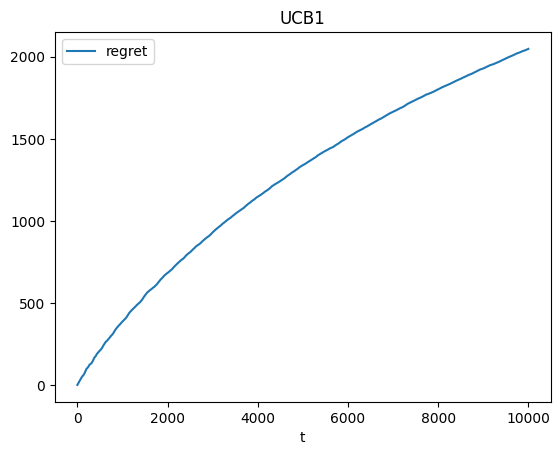

In [24]:
# DO NOT MODIFY
np.random.seed(SEED)
ucb1_df = run_repeated_experiments(UCB1, SEED)
ucb1_df.plot(x='t', y='regret', title='UCB1')

### Problem 4
(6 points) 

This theory problem is based on **Exercise 1.1** in [Bandits]. The proofs in **Chapter 1** consider environments where the rewards are in the interval $[0,1]$. Consider the case when we have additional knowledge about about the problem and that we know that the rewards for each action are in the interval $\left[\frac{1}{2}, \frac{1}{2} + \epsilon\right]$ for some fixed $\epsilon \in \left(0, \frac{1}{2}\right)$. 

Consider a version of $\text{UCB1}$ modified to utilize this knowledge (you do not need to specify the algorithm completely, just define the new confidence radius $r_t(a)$). For this algorithm and problem setting, prove that:

$\mathbb{E}\left[R(t)\right] \leq \frac{2 \epsilon t}{T^2} + 2 \epsilon \sqrt{2 K t \log T}$

**Instructions:** Use a version of Hoeffding Inequality with ranges (**Theorem A.2** in the [Bandits] book) to modify the confidence radius $r_t(a)$. Subsequently follow the steps of the analysis leading up to **Theorem 1.14** in [Bandits] to derive the regret bound, though show the actual constants instead of using big O notation:

1. Define the clean event, like in **Section 1.3.1**, and lower bound the probability of the event.
2. Start with the definition of the regret $\mathbb{E}\left[R(t)\right]$, and perform a regret decomposition like on **Page 11** of **Section 1.3.2**.
3. Bound the *gap* $\Delta (a_t)$, like in **Section 1.3.3**.
4. Complete the proof using the technique on **Page 12** of **Section 1.3.2**. Note that applying the bound in step 3 requires careful motivation.

*Write the solution in the Markdown cell below (use LaTeX-math mode for equations, etc.).*

#### Solution

Hoeffdin Inequality equation: $ Pr\left [ \left| \bar{X_n}-\mu _n \right|\leq \sqrt{\frac{\alpha \beta \log(T)}{n}} \right ]\geq 1-2\cdot T^{-2\alpha } $, 

with $\beta = \frac{1}{n}\sum_{i \in n}(u_i-l_i)^2 = \frac{1}{n}\sum_{i \in n}((\frac{1}{2} +\epsilon)-\frac{1}{2})^2 = n \cdot \frac{\epsilon^2}{n} = \epsilon^2$ 

The new confidence radius is $r_t(a)=\sqrt{\frac{2\epsilon^2\log T}{n}}$, the clean event becomes

$\Epsilon := \{\forall a \forall t \quad |\bar{\mu}(a) - \mu(a)| \leq r_t(a) = |\bar{\mu}(a) - \mu(a) | \leq \sqrt{\frac{2\epsilon^2\log T}{n}}\}$ 

$\text{Pr}[\Epsilon] \geq 1-\frac{2}{T^2}$


## Bayesian Bandits (Chapter 3)

### Problem 5
(3 points)

Implement the *Thompson Sampling* algorithm (**Algorithm 3.3** in [Bandits]) within the provided bandit algorithm template below. Assume independent priors and that the prior is $\mathbb{P} = \text{Beta}(\alpha_0, \beta_0)$ with $\alpha_0 = 1$ and $\beta_0 = 1$ (i.e. the **Beta-Bernoulli** setting, on **page 35** in [Bandits]).

**Note:** There is a typo in the expression for the posterior $\mathbb{P}_H$ in [Bandits]. It should be $\text{Beta}(\alpha_0 + \text{REW}_H,\ \beta_0 + t - \text{REW}_H)$.

In [32]:
class ThompsonSampling(BanditAlgorithmBase):
    def __init__(self, T, K):
        """
        Constructor for Thompson Sampling algorithm
        
        Parameters
        ----------
        T : int
            Horizon (number of time steps)
        K : int
            Number of arms (actions)
        """
        self.T = T
        self.K =  K
        self.rewards = np.zeros(K)
        self.times_tested = np.zeros(K)

        # P_H = Beta(1 + reward_history, 1+t -  reward_history)
    
    def select_action(self):
        """
        Select an action which will be performed in the environment in the 
        current time step

        Returns
        -------
        An action index (integer) in [0, K-1]
        """

    # for each round t = 1, 2, . . . do
        # Observe H_(t−1) = H, for some feasible (t − 1)-history H;
        # For each arm a, sample mean reward μt(a) independently from distribution Pa_H ;
        # Choose an arm with largest μt(a).
    # end
        
        # FILL IN CODE HERE

        # Compute the Probability Density Function (PDF) at each x

        p_H = np.random.beta(1+self.rewards, 1 + self.times_tested - self.rewards)

        return np.argmax(p_H)

        
    
    def update(self, action, reward):
        """
        Update the bandit algorithm with the reward received from the 
        environment for the action performed in the current time step

        Parameters
        ----------
        action : int
            An action index (integer) in [0, K-1]
        reward : int
            Reward (integer) in {0, 1} (Bernoulli rewards)

        """
        
        # FILL IN CODE HERE
        self.rewards[action] += reward
        self.times_tested[action] += 1


Run the algorithm in the provided environment using the code below (averaging regret over 5 runs). The plot should show sublinear regret with respect to $t$.

<Axes: title={'center': 'Thompson Sampling'}, xlabel='t'>

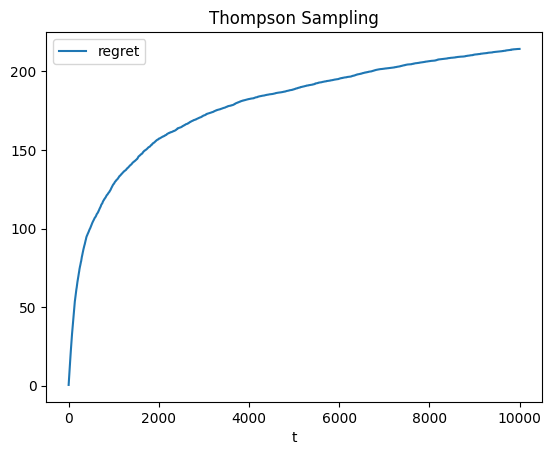

In [41]:
# DO NOT MODIFY
np.random.seed(SEED)
ts_df = run_repeated_experiments(ThompsonSampling, SEED)
ts_df.plot(x='t', y='regret', title='Thompson Sampling')

### Problem 6
(6 points)

In this theory problem, you will show an intermediary step in the proof for the Bayesian regret bound of *Thompson Sampling* in the [Bandits] book.

You are given a $K$-armed bandit problem with rewards in the interval $[0, 1]$. You can assume that $K \leq T$, where $T$ is the horizon. Additionally, you can assume that **Lemma 1.5** holds (i.e., for this assignment we define $r_t (a) := \sqrt{\frac{2  \log T}{ n_t (a)}}$, and then it holds that $\text{Pr}\left\{ \mathcal{E} \right\} \geq 1 - \frac{2}{T^2}$ with $\mathcal{E} := \left\{ \forall a \forall t \;\; \vert \bar{\mu}_t (a) - \mu (a) \vert \leq r_t (a) \right\}$). Then, with $\text{UCB}_t (a) := \bar{\mu}_t (a) + r_t (a)$, show that $\mathbb{E}\left[ \left[ \text{UCB}_t (a) - \mu (a) \right]^{-} \right] \leq \frac{2}{TK}$ (i.e., show that Equation 3.14 in [Bandits], with $\gamma = 2$, holds for all arms $a$ and rounds $t$).

**Note:** $[x]^{-}$ is the negative portion of $x$, i.e., $[x]^{-} = 0$ if $x \geq 0$ and $[x]^{-} = \vert x \vert$ otherwise.

**Hint:** Remember that, given a random variable $X$, an event $\mathcal{E}$ (subset of the sample space) and its complement $\mathcal{E}^c$, by the tower rule, $\mathbb{E}\left[ X \right] = \mathbb{E}\left[ X \;\vert\; \mathcal{E} \right] \cdot \text{Pr}\left\{ \mathcal{E} \right\} + \mathbb{E}\left[ X \;\vert\; \mathcal{E}^c \right] \cdot \text{Pr}\left\{ \mathcal{E}^c \right\}$.

#### Solution

Given Lemma 1.5 and assuming that $K \leq T$, we can rewrite $\Pr\{\epsilon\} \geq 1 - \frac{2}{TK}$.

On the event $\epsilon$, we have 

\begin{equation*}
|\bar{\mu}_t(a) - \mu(a)| \leq r_t(a) \implies \bar{\mu}_t(a) \geq \mu(a) - r_t(a).
\end{equation*}

So we would have 

\begin{equation*}
\text{UCB}_t(a) = \bar{\mu}_t(a) + r_t(a) \geq \mu(a) - r_t(a) + r_t(a) = \mu(a),
\end{equation*}

and since $\text{UCB}_t(a) - \mu(a) \geq 0$, then 

\begin{equation*}
\mathbb{E} \left[ \left(\text{UCB}_t(a) - \mu(a)\right)^- \right] = 0.
\end{equation*}

We can then bound the complement by saying that it is $\leq 1$, i.e.,

\begin{equation*}
\mathbb{E} \left[ \left(\text{UCB}_t(a) - \mu(a)\right)^- \mathbb{I}_{\{ \epsilon^c \}} \right] \leq 1.
\end{equation*}

Using the law of total expectation, we can then get rid of the non-complement part since it is equal to zero, and we can use only the formula rearranged from Lemma 1.5:

\begin{equation*}
\mathbb{E} \left[ \left(\text{UCB}_t(a) - \mu(a)\right)^- \right] \leq 0 \cdot \Pr\{\epsilon\} + 1 \cdot \Pr\{\epsilon^c\} = \Pr\{\epsilon^c\}.
\end{equation*}

i.e.,

\begin{equation*}
\mathbb{E} \left[ \left(\text{UCB}_t(a) - \mu(a)\right)^- \right] \leq \frac{2}{TK}.
\end{equation*}

## Final comparison

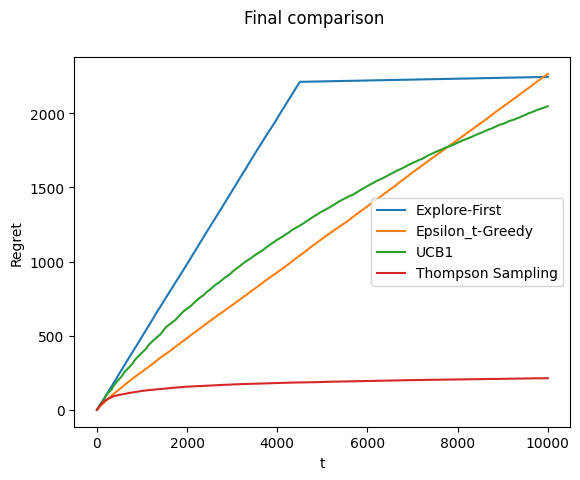

In [38]:
fig, ax = plt.subplots(1,1)
fig.suptitle("Final comparison")
ax.set_xlabel("t"); ax.set_ylabel("Regret")
dfs = [(ef_df, "Explore-First"), (eg_df, "Epsilon_t-Greedy"), (ucb1_df, "UCB1"), (ts_df, "Thompson Sampling")]
for df, label in dfs: df.plot(x='t', y='regret',ax = ax, label = label) 

## Bonus: KL-UCB 

(0 points)

As we explored in Problem 4, UCB1 relies on Hoeffding's inequality to determine the confidence radius. Hoeffding's inequality assumes that the reward is bounded (or more generally that they are sub-Gaussian). However, in this assignment we know that the rewards are Bernoulli distributed. As such, Hoeffding's inequality is too general to ensure optimal performance. 

KL-UCB is an upper confidence algorithm that uses the following selection rule (after sampling every arm once):
$$
a_t = \argmax_{a} \max_{\tilde{\mu}} \Big\{ \tilde \mu \in [0,1] : d(\bar{\mu}_t(a), \tilde \mu) \leq \frac{\log f(t)}{n_{t}(a)} \Big\}
$$
where $f(t) = 1 + t \log^2(t)$ and $d(p, q) = p \log \frac{p}{q} + (1-p) \log \frac{1-p}{1-q}$ is the KL-divergence between two Bernoulli distributions with mean $p \in (0,1)$ and $q \in (0,1)$. Note that $d(p,q)$ is undefined for $p$ or $q$ in $\{0,1\}$.

As a bonus exercise, implement KL-UCB and compare its performance against UCB1. Since KL-UCB relies on tighter concentration inequalities, we would expect KL-UCB to accumulate less regret than UCB1. 

If you are up for it, try making your implementation computationally efficient.

In [39]:
class KLUCB(BanditAlgorithmBase):
    def __init__(self, T, K):
        """
        Constructor of the bandit algorithm

        Parameters
        ----------
        T : int
            Horizon
        K : int
            Number of actions
        """
        
        # FILL IN CODE HERE
        pass
    
    def select_action(self):
        """
        Select an action which will be performed in the environment in the 
        current time step

        Returns
        -------
        An action index (integer) in [0, K-1]
        """
        
        # FILL IN CODE HERE
        pass
    
    def update(self, action, reward):
        """
        Update the bandit algorithm with the reward received from the 
        environment for the action performed in the current time step

        Parameters
        ----------
        action : int
            An action index (integer) in [0, K-1]
        reward : int
            Reward (integer) in {0, 1} (Bernoulli rewards)

        """
        
        # FILL IN CODE HERE
        pass

In [40]:
# DO NOT MODIFY
np.random.seed(SEED)
klucb_df = run_repeated_experiments(KLUCB, SEED)
klucb_df.plot(x='t', y='regret', title='KL-UCB')

ValueError: setting an array element with a sequence.

In [ ]:
fig, ax = plt.subplots(1,1)
fig.suptitle("Final comparison")
ax.set_xlabel("t"); ax.set_ylabel("Regret")
dfs = [(ef_df, "Explore-First"), (eg_df, "Epsilon_t-Greedy"), (ucb1_df, "UCB1"), (ts_df, "Thompson Sampling"), (klucb_df, "KL-UCB")]
for df, label in dfs: df.plot(x='t', y='regret',ax = ax, label = label) 